In [133]:
import os

import matplotlib.pyplot as plt
import mlflow
import numpy as np

from nowcasting.unet import res2
from nowcasting.utils import CustomGenerator

In [134]:
mlflow.set_tracking_uri("../mlruns")

In [135]:
dataset = "12_8_0_20_1.0"
train_directory = f"../data/datasets/{dataset}/train/"
val_directory = f"../data/datasets/{dataset}/val/"

In [136]:
train_paths = [f"{train_directory}/{x}" for x in os.listdir(train_directory)]
train_dataset = CustomGenerator(train_paths, 1, shuffle=False)

val_paths = [f"{val_directory}/{x}" for x in os.listdir(val_directory)]
val_dataset = CustomGenerator(val_paths, 1, shuffle=False)

In [137]:
experiment_id = mlflow.get_experiment_by_name(
    f"hpo_res_mse_12_8_0_20_1.0").experiment_id
print(experiment_id)
df = mlflow.search_runs(experiment_id)

498167589692783847


In [138]:
df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.val_mae,metrics.stopped_epoch,metrics.val_mse,metrics.lr,...,params.validation_batch_size,params.use_multiprocessing,params.validation_steps,params.opt_dynamic_growth_steps,params.workers,tags.mlflow.runName,tags.mlflow.source.git.commit,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.source.name
0,e8215f58f40646859c0a040347298e05,498167589692783847,FINISHED,file:///panfs/jay/groups/6/csci8523/joren015/r...,2022-11-29 15:48:09.761000+00:00,2022-11-29 17:54:16.570000+00:00,0.110718,28.0,1.019580,1.000000e-14,...,None,False,None,2000,1,sneaky-squirrel-928,fae7ba7c65ae15d4368c1f3bbe172e1c555ebae6,LOCAL,joren015,hpo.py
1,9dee839e83cf400abf436513716f4a87,498167589692783847,FINISHED,file:///panfs/jay/groups/6/csci8523/joren015/r...,2022-11-29 14:41:14.466000+00:00,2022-11-29 15:48:04.440000+00:00,0.110479,25.0,1.021161,1.000000e-14,...,None,False,None,2000,1,treasured-hog-491,fae7ba7c65ae15d4368c1f3bbe172e1c555ebae6,LOCAL,joren015,hpo.py
2,96c64f2f349349858984ef7d21e7e47f,498167589692783847,FINISHED,file:///panfs/jay/groups/6/csci8523/joren015/r...,2022-11-29 09:16:07.829000+00:00,2022-11-29 14:41:09.044000+00:00,0.339590,73.0,1.014495,1.000000e-06,...,None,False,None,2000,1,gaudy-snail-730,fae7ba7c65ae15d4368c1f3bbe172e1c555ebae6,LOCAL,joren015,hpo.py
3,65bebbb5b293463fba644bd4a72610b3,498167589692783847,FINISHED,file:///panfs/jay/groups/6/csci8523/joren015/r...,2022-11-29 08:06:33.529000+00:00,2022-11-29 09:16:02.462000+00:00,0.109575,25.0,1.020001,1.000000e-14,...,None,False,None,2000,1,auspicious-hen-353,fae7ba7c65ae15d4368c1f3bbe172e1c555ebae6,LOCAL,joren015,hpo.py
4,a999150f1bb94702877753381765188f,498167589692783847,FINISHED,file:///panfs/jay/groups/6/csci8523/joren015/r...,2022-11-29 06:12:10.636000+00:00,2022-11-29 08:06:28.206000+00:00,0.109390,25.0,1.019840,1.000000e-14,...,None,False,None,2000,1,awesome-gull-520,fae7ba7c65ae15d4368c1f3bbe172e1c555ebae6,LOCAL,joren015,hpo.py
5,9bde0859e293406c89fcbc142db69932,498167589692783847,FINISHED,file:///panfs/jay/groups/6/csci8523/joren015/r...,2022-11-29 04:03:43.291000+00:00,2022-11-29 06:12:05.110000+00:00,0.161781,28.0,0.973475,1.000000e-06,...,None,False,None,2000,1,intelligent-cat-133,fae7ba7c65ae15d4368c1f3bbe172e1c555ebae6,LOCAL,joren015,hpo.py
6,f8f7c5a6bd6446fc9c75b84d9817c97c,498167589692783847,FINISHED,file:///panfs/jay/groups/6/csci8523/joren015/r...,2022-11-29 03:22:58.277000+00:00,2022-11-29 06:53:18.695000+00:00,0.144939,82.0,0.880951,1.000000e-06,...,None,False,None,2000,1,dashing-worm-194,fae7ba7c65ae15d4368c1f3bbe172e1c555ebae6,LOCAL,joren015,hpo.py
7,6d86ec6044bb4004a3f43906f2e694c7,498167589692783847,FINISHED,file:///panfs/jay/groups/6/csci8523/joren015/r...,2022-11-29 01:25:03.116000+00:00,2022-11-29 03:22:52.796000+00:00,0.111531,26.0,1.019540,9.999999e-11,...,None,False,None,2000,1,rumbling-sloth-937,fae7ba7c65ae15d4368c1f3bbe172e1c555ebae6,LOCAL,joren015,hpo.py
8,28b391d02fd34ecb906f973e63862cab,498167589692783847,FINISHED,file:///panfs/jay/groups/6/csci8523/joren015/r...,2022-11-29 01:23:15.882000+00:00,2022-11-29 04:03:37.862000+00:00,0.111387,36.0,1.019189,9.999999e-12,...,None,False,None,2000,1,spiffy-hog-335,fae7ba7c65ae15d4368c1f3bbe172e1c555ebae6,LOCAL,joren015,hpo.py
9,bdce4c14270c4cb28ca0f0d8ebc945cf,498167589692783847,FINISHED,file:///panfs/jay/groups/6/csci8523/joren015/r...,2022-11-29 00:13:53.335000+00:00,2022-11-29 01:24:57.679000+00:00,0.114960,25.0,1.020724,1.000000e-14,...,None,False,None,2000,1,judicious-loon-926,fae7ba7c65ae15d4368c1f3bbe172e1c555ebae6,LOCAL,joren015,hpo.py


In [139]:
non_zero_runs = []
for i in range(len(df)):
    row = df.iloc[i]
    run_id = row["run_id"]
    num_filters_base = int(row["params.hpo_num_filters_base"])
    model = res2((12, 256, 620, 4),
                 num_filters_base=num_filters_base,
                 dropout_rate=0)
    model.load_weights(
        f"../mlruns/{experiment_id}/{run_id}/artifacts/script_n1.h5")
    y_hat = model.predict(val_dataset)
    non_zero_output = np.count_nonzero(y_hat[y_hat > np.mean(y_hat)])
    print(non_zero_output)
    if non_zero_output > 100:
        non_zero_runs.append({
            "weights":
            f"../mlruns/{experiment_id}/{run_id}/artifacts/script_n1.h5",
            "num_filters_base": num_filters_base,
            "non_zero_output": non_zero_output,
            "val_mse": row["metrics.val_mse"],
            "run_name": row["tags.mlflow.runName"]
        })


10/10 [==============================] - 8s 283ms/step
3955046
10/10 [==============================] - 8s 236ms/step
8819651
10/10 [==============================] - 8s 235ms/step
2039748
10/10 [==============================] - 8s 277ms/step
8167088
10/10 [==============================] - 8s 277ms/step
3208807
10/10 [==============================] - 8s 276ms/step
2325446
10/10 [==============================] - 8s 240ms/step
2394245
10/10 [==============================] - 9s 276ms/step
3497847
10/10 [==============================] - 8s 277ms/step
3576424
10/10 [==============================] - 8s 278ms/step
8831422
10/10 [==============================] - 8s 234ms/step
2950175


In [140]:
print(len(non_zero_runs))

11


In [142]:
non_zero_runs

[{'weights': '../mlruns/498167589692783847/e8215f58f40646859c0a040347298e05/artifacts/script_n1.h5',
  'num_filters_base': 8,
  'non_zero_output': 3955046,
  'val_mse': 1.019580364227295,
  'run_name': 'sneaky-squirrel-928'},
 {'weights': '../mlruns/498167589692783847/9dee839e83cf400abf436513716f4a87/artifacts/script_n1.h5',
  'num_filters_base': 4,
  'non_zero_output': 8819651,
  'val_mse': 1.0211611986160278,
  'run_name': 'treasured-hog-491'},
 {'weights': '../mlruns/498167589692783847/96c64f2f349349858984ef7d21e7e47f/artifacts/script_n1.h5',
  'num_filters_base': 4,
  'non_zero_output': 2039748,
  'val_mse': 1.0144950151443481,
  'run_name': 'gaudy-snail-730'},
 {'weights': '../mlruns/498167589692783847/65bebbb5b293463fba644bd4a72610b3/artifacts/script_n1.h5',
  'num_filters_base': 8,
  'non_zero_output': 8167088,
  'val_mse': 1.020000696182251,
  'run_name': 'auspicious-hen-353'},
 {'weights': '../mlruns/498167589692783847/a999150f1bb94702877753381765188f/artifacts/script_n1.h5',


In [141]:
non_zero_run = non_zero_runs[6]
print(non_zero_run)
model = res2((12, 256, 620, 4),
             num_filters_base=non_zero_run["num_filters_base"],
             dropout_rate=0)
model.load_weights(non_zero_run["weights"])
model.compile(loss="mean_absolute_error", metrics=["mae", "mse"])


{'weights': '../mlruns/498167589692783847/f8f7c5a6bd6446fc9c75b84d9817c97c/artifacts/script_n1.h5', 'num_filters_base': 4, 'non_zero_output': 2394245, 'val_mse': 0.8809508681297302, 'run_name': 'dashing-worm-194'}


In [110]:
model.evaluate(train_dataset)

10/10 [==============================] - 10s 235ms/step - loss: 0.1157 - mae: 0.1157 - mse: 0.6061


[0.11573346704244614, 0.11573346704244614, 0.6061096787452698]

In [111]:
model.evaluate(val_dataset)

10/10 [==============================] - 2s 233ms/step - loss: 0.1517 - mae: 0.1517 - mse: 0.6524


[0.15168175101280212, 0.15168175101280212, 0.6524056196212769]

In [151]:
y_pred = model.predict(val_dataset)

10/10 [==============================] - 2s 231ms/step


In [152]:
print(np.min(y_pred))

-0.08964507


In [153]:
# y_pred[y_pred < 0.1] = 0

In [154]:
k = 5
X, y = train_dataset.__getitem__(k)
X = X[0]
y = y[0]
y_hat = y_pred[k]

Input


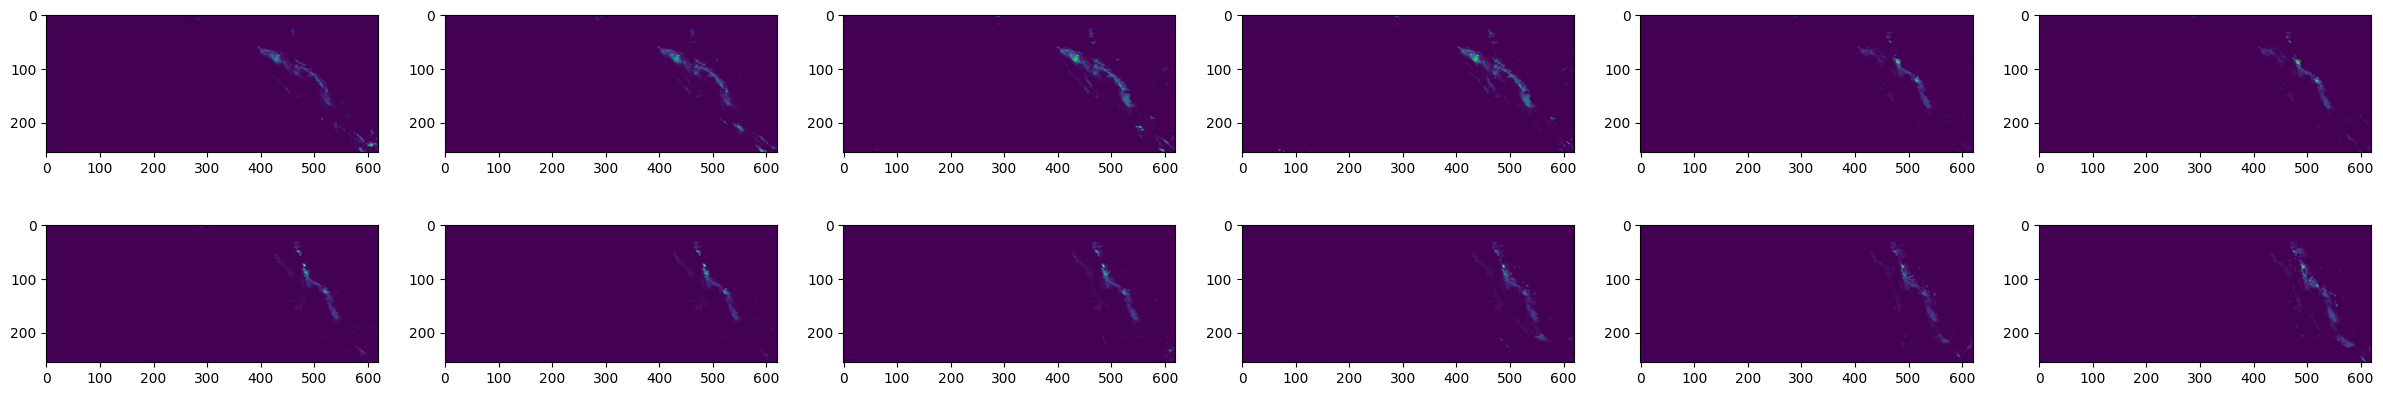

In [155]:
print("Input")
fig, axs = plt.subplots(2, 6, figsize=(30, 5))

for i in range(2):
    for j in range(6):
        axs[i, j].imshow(X[i * 6 + j, :, :, 0])

Target


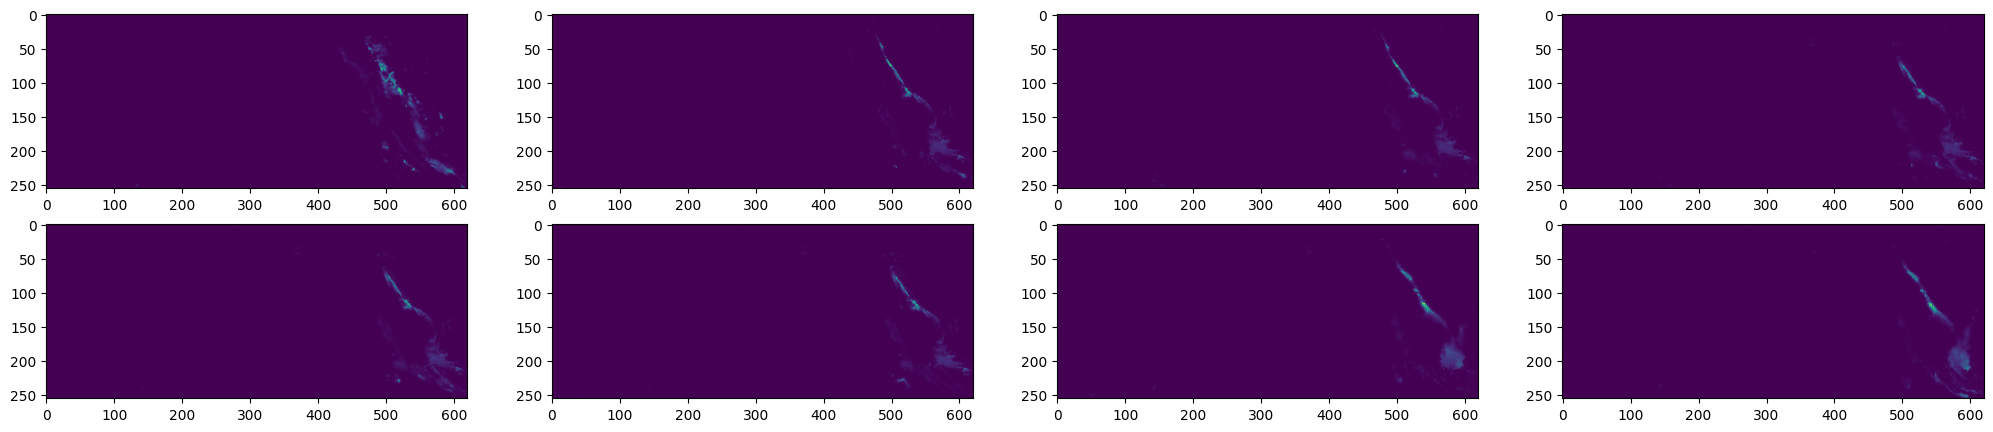

In [156]:
print("Target")
fig, axs = plt.subplots(2, 4, figsize=(25, 5))

for i in range(2):
    for j in range(4):
        axs[i, j].imshow(y[i * 4 + j, :, :, 0])

Prediction


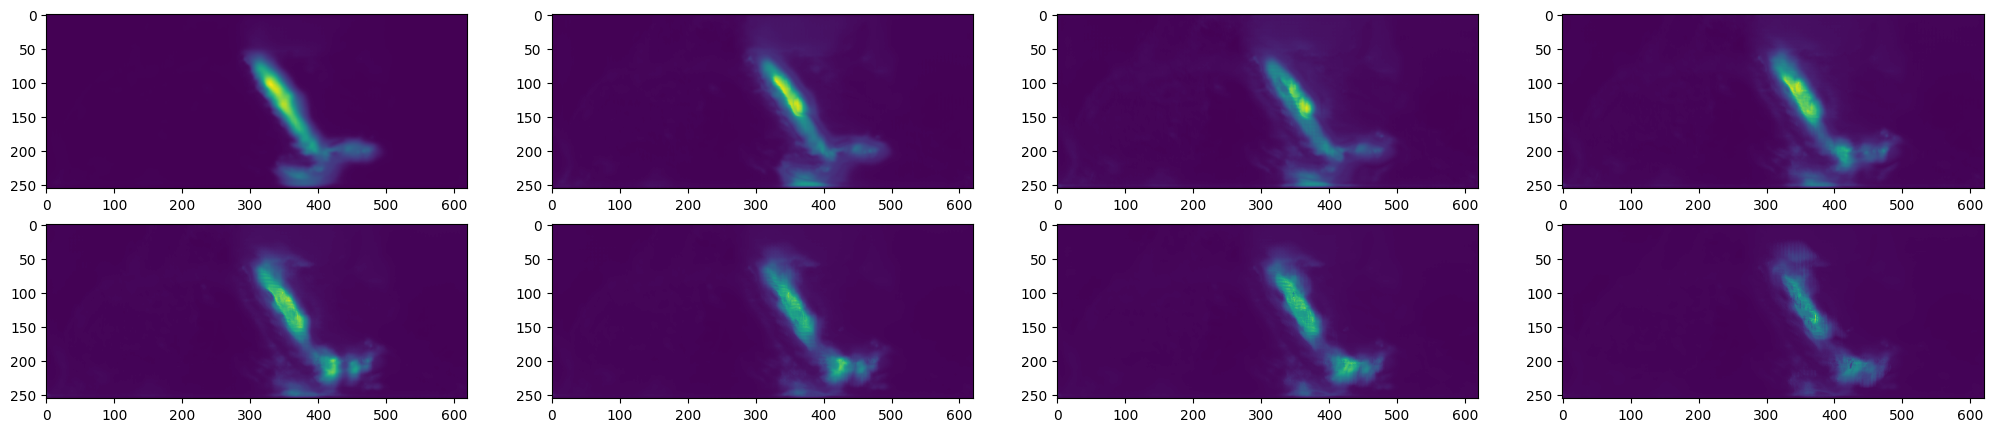

In [157]:
print("Prediction")
fig, axs = plt.subplots(2, 4, figsize=(25, 5))

for i in range(2):
    for j in range(4):
        axs[i, j].imshow(y_hat[i * 4 + j, :, :])

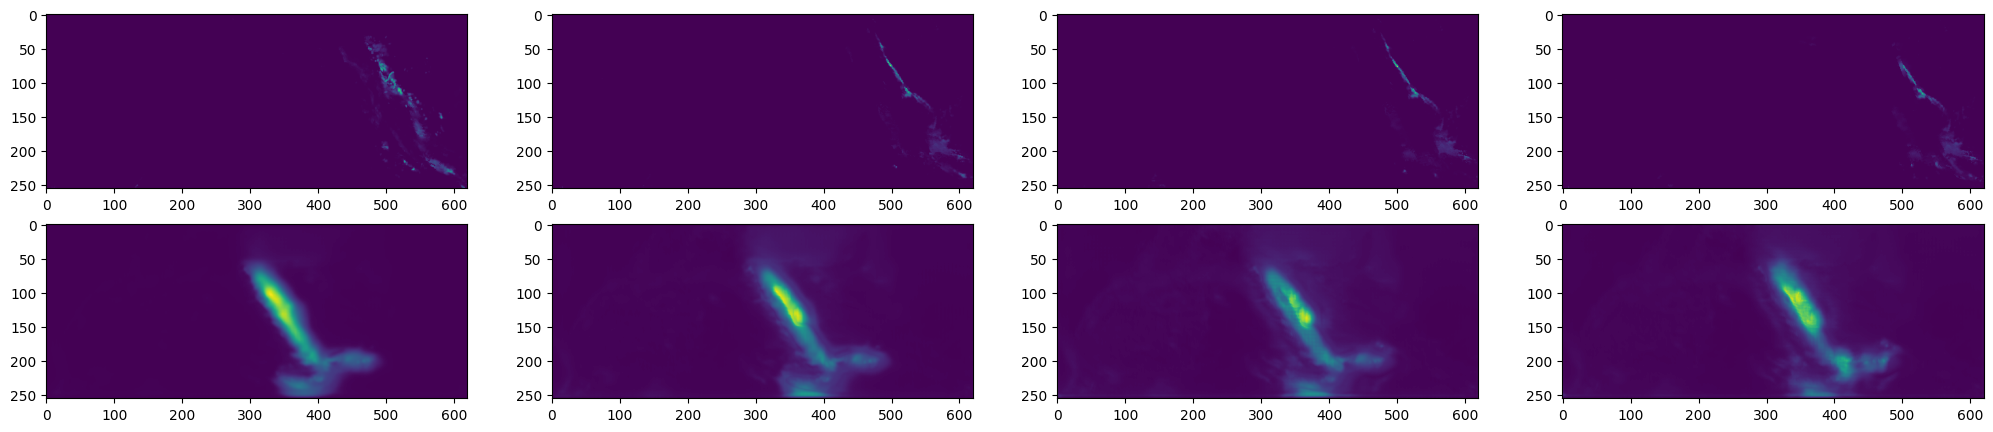

In [158]:
fig, axs = plt.subplots(2, 4, figsize=(25, 5))

for j in range(4):
    axs[0, j].imshow(y[j, :, :, 0])
    axs[1, j].imshow(y_hat[j, :, :])